# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

In [4]:
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
from numpy import random


In [17]:
FRAME_TIME = 0.2  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
BOOST_ACCEL2 = 0.18
DRAG_COEFF = .06
AREA = .05
AIR_DENS = .012
MASS = .1
WIND = 2
#create random initial conditions for the rocket
s1= 2 * np.random.rand()
s2= 2 * np.random.rand()
s3= 2 * np.random.rand()
s4= 2 * np.random.rand()
print(s1)
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

0.10333280841284953


In [18]:
# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        state[2] = x
        state[3] = x_dot
        """
        
        # Apply gravity
        delta_state_gravity = t.tensor([0.,(GRAVITY_ACCEL * FRAME_TIME), 0., 0.])
        
        # Drag
        delta_state_drag = (t.tensor([0., -1., 0., 0.])*((( DRAG_COEFF * AREA * ((AIR_DENS * state[1]**2)/2))/MASS) * FRAME_TIME))
        
        # Introduce an x direction wind to the model  
        delta_state_drag_WIND = (t.tensor([0., 0., 0., 1])*((( DRAG_COEFF * AREA * ((AIR_DENS * WIND**2)/2))/MASS) * FRAME_TIME))
        delta_state_drag_x = (t.tensor([0., 0., 0., 1.])*((( DRAG_COEFF * AREA * ((AIR_DENS * state[3]**2)/2))/MASS) * FRAME_TIME))
        
        # Thrust
        #Here i built my model around the use of 3 thrusters up, left,and right
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        delta_state_x_n = BOOST_ACCEL2 * FRAME_TIME * action[1] * t.tensor([0., 0., 0., -1.])
        delta_state_x_p = BOOST_ACCEL2 * FRAME_TIME * action[2] * t.tensor([0., 0., 0., 1.])
        
        # Update velocity
        state = state + delta_state_y + delta_state_gravity + delta_state_drag + delta_state_x_p + delta_state_drag_WIND + delta_state_x_n
        
        # Update state
        # Here we update the state vector by multiplying the velocity by time and adding the previous position for both x and y
        step_mat = t.tensor([[1., FRAME_TIME,0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1]])
        state = t.matmul(step_mat, state)

        return state
        

In [19]:
class Controller(nn.Module):
    
    def __init__(self, dim_input, dim_hidden, dim_output):
        
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(), 
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        action = self.network(state)
        return action

In [20]:

class Simulation(nn.Module):
    
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        
    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)
    
    @staticmethod
    def initialize_state():
        state = [s1, s2, s3, s4]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        states = state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2
        height = t.matmul(t.stack(self.state_trajectory),t.tensor([1., 0., 0., 0.]))
        position = t.matmul(t.stack(self.state_trajectory),t.tensor([0., 0., 1., 0.]))
        penalty = t.nn.functional.relu(-height).sum(dim=0) # introduce penalty funtion if height is less than 0
        return states + (1 * penalty)

In [21]:
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        self.loss_trajectory = []
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()
            loss1 = np.array([loss.detach().numpy()])
            self.loss_trajectory.append(loss1)
        plt.plot(self.loss_trajectory)
        plt.title("Convergence Plot")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.show()
        
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        i = data[:, 2]
        j = data[:,3]
        plt.plot(x, y)
        plt.xlabel("Y Position")
        plt.ylabel("Y Velocity")
        plt.show()
        plt.plot(i, j)
        plt.xlabel("X Position")
        plt.ylabel("X Velocity")
        plt.show()
        plt.plot(i, x)
        plt.title("Rocket path")
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.show()

[1] loss: 17.017


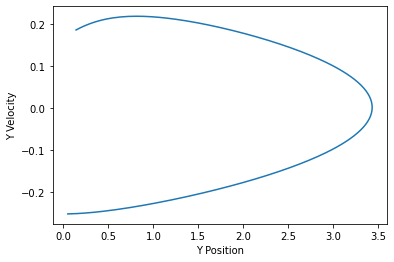

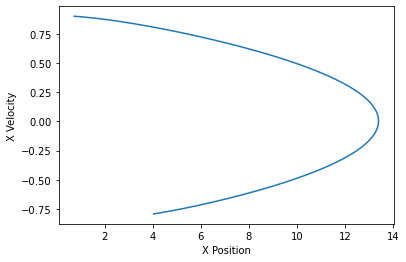

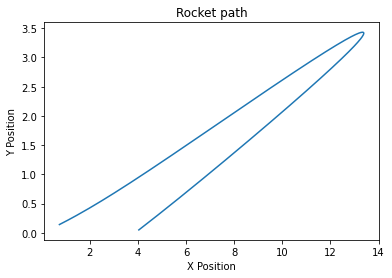

[2] loss: 11.853


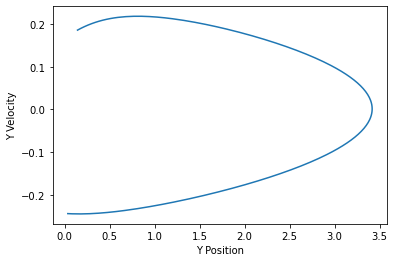

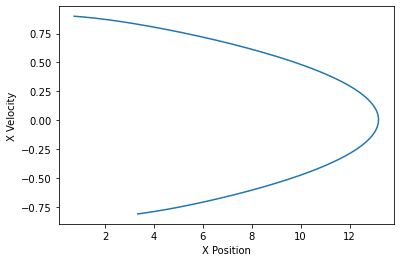

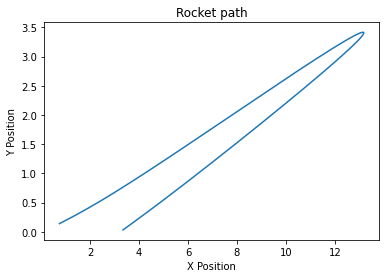

[3] loss: 8.332


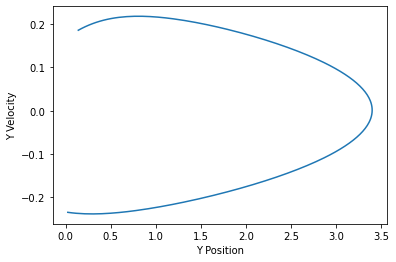

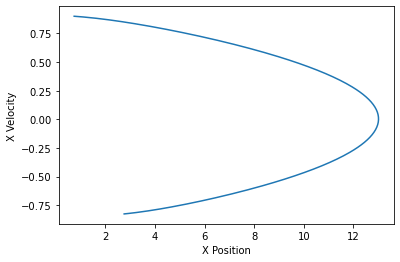

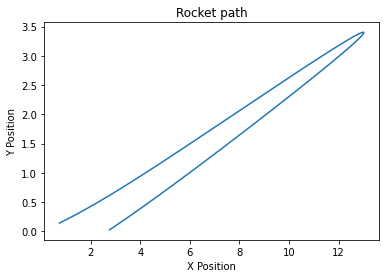

[4] loss: 5.927


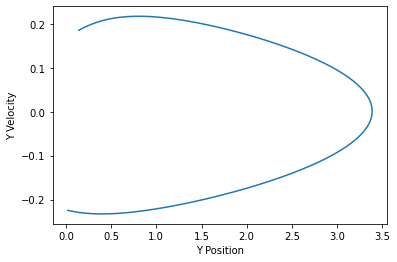

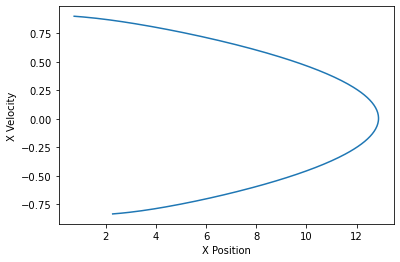

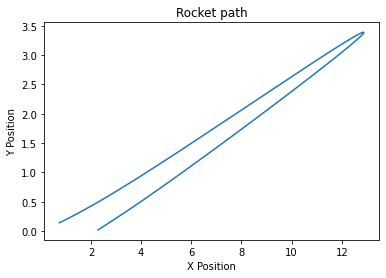

[5] loss: 4.283


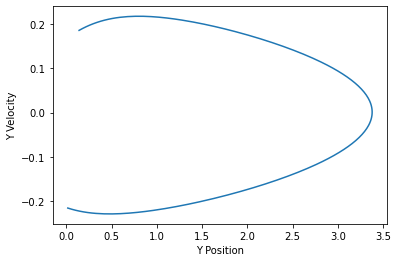

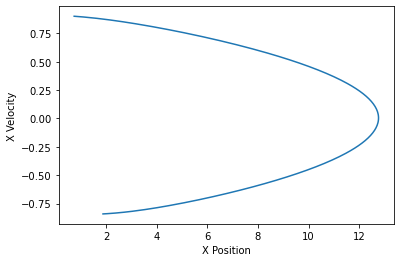

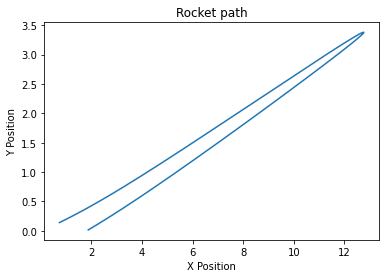

[6] loss: 3.157


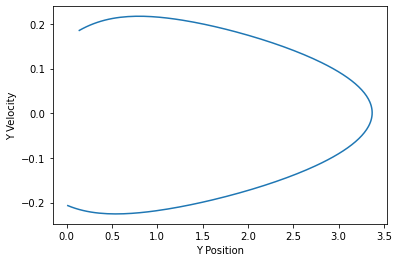

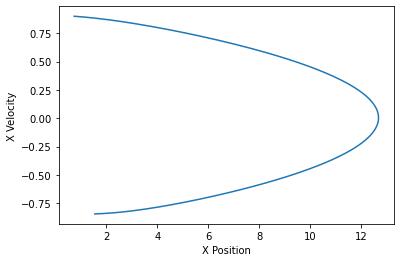

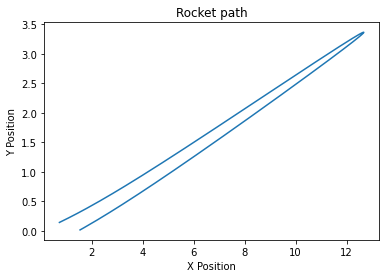

[7] loss: 2.387


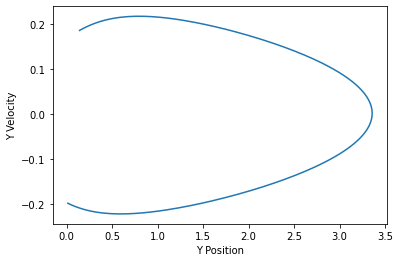

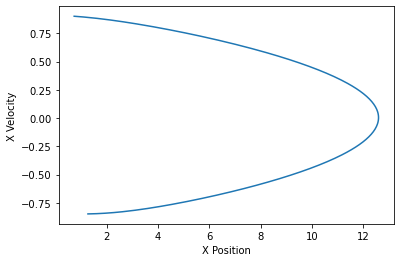

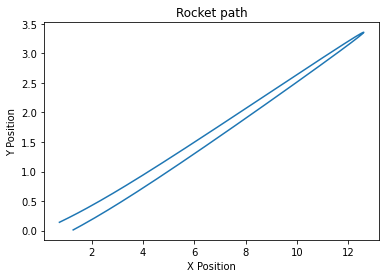

[8] loss: 1.860


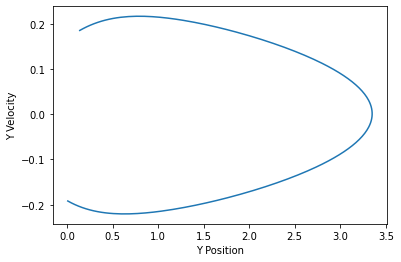

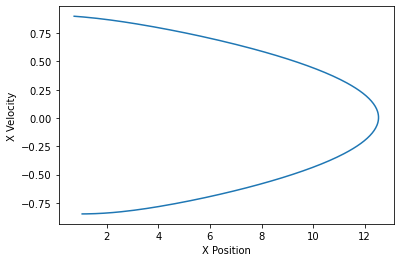

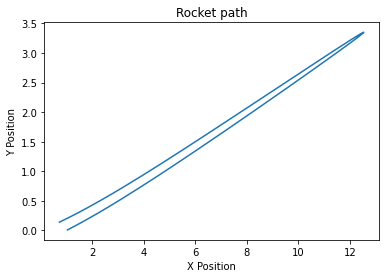

[9] loss: 1.500


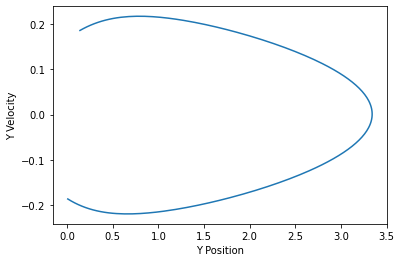

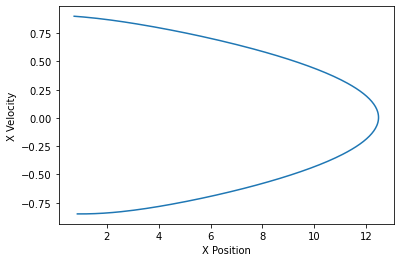

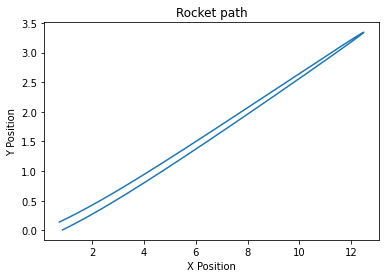

[10] loss: 1.254


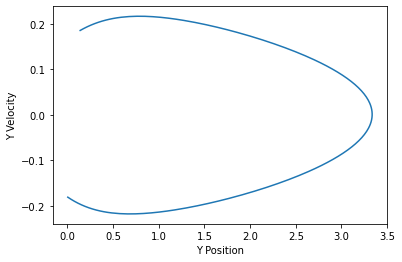

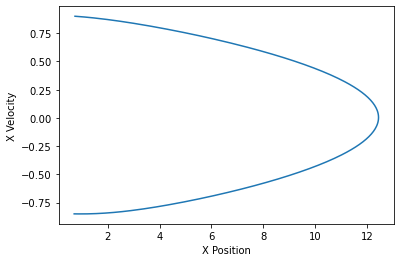

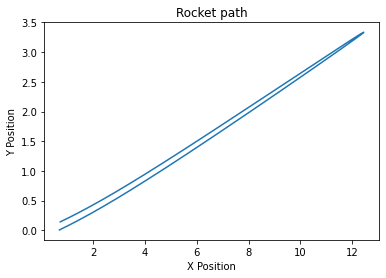

[11] loss: 1.087


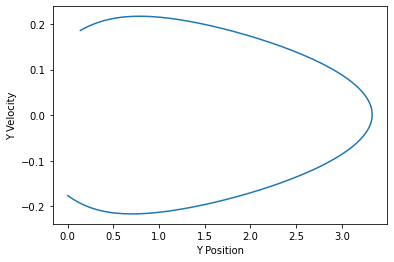

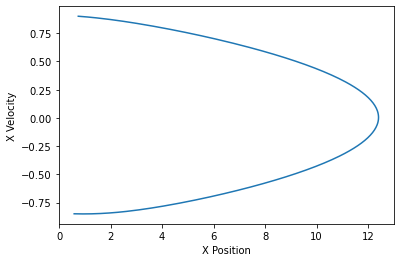

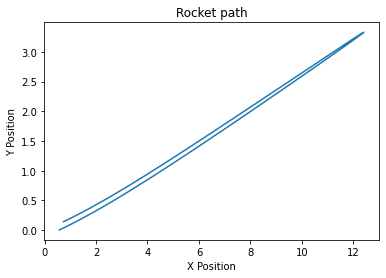

[12] loss: 0.974


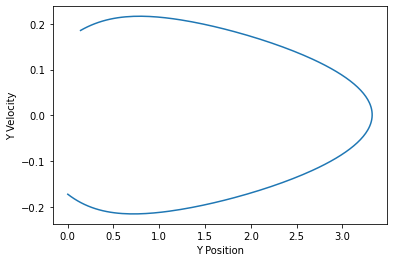

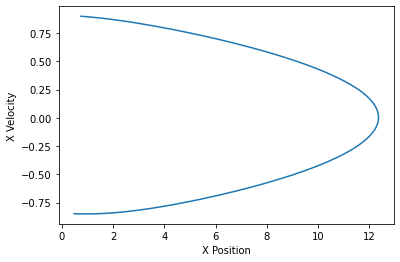

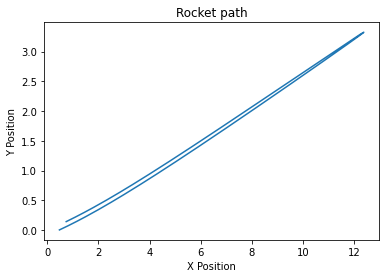

[13] loss: 0.897


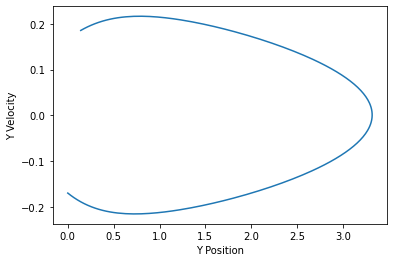

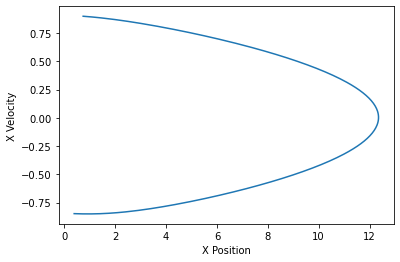

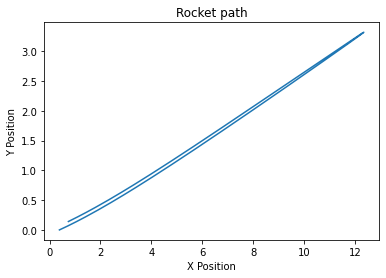

[14] loss: 0.845


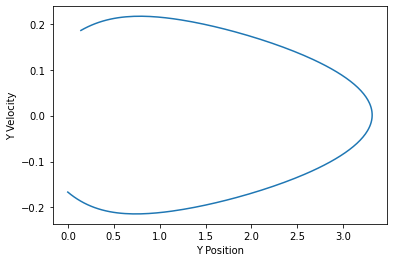

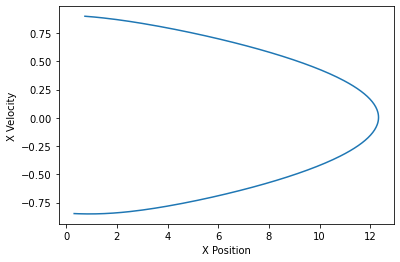

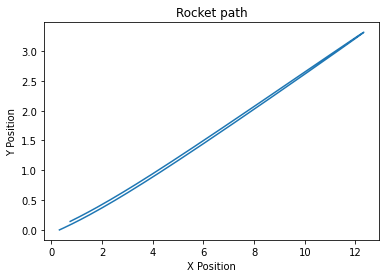

[15] loss: 0.810


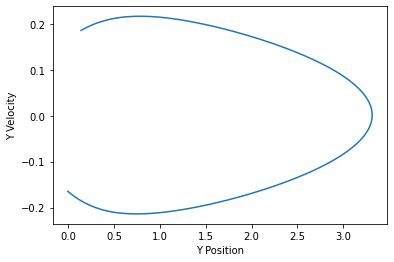

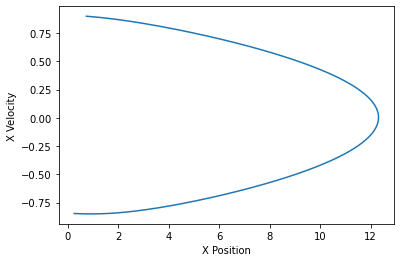

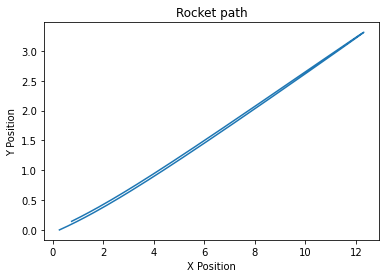

[16] loss: 0.786


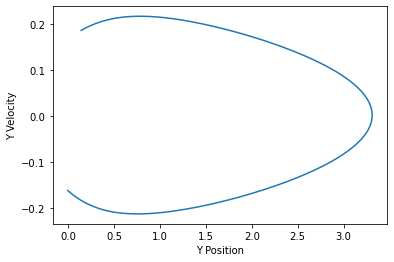

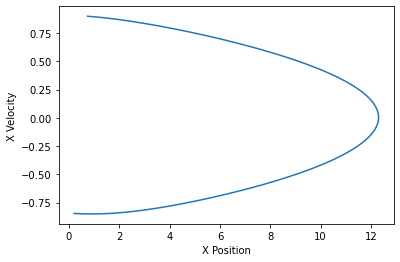

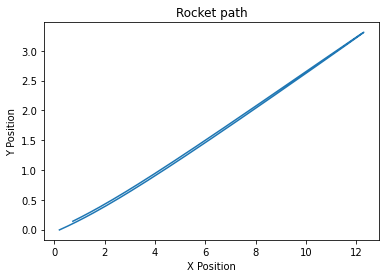

[17] loss: 0.770


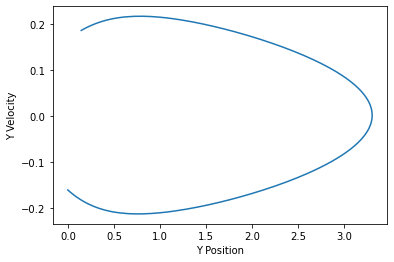

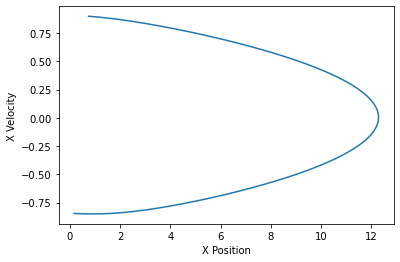

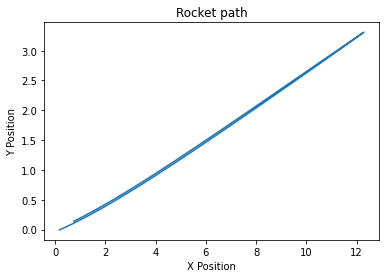

[18] loss: 0.759


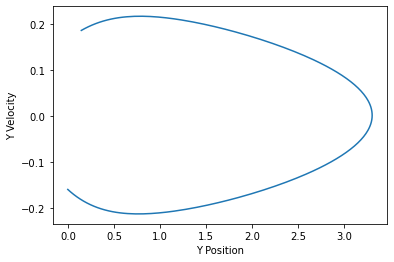

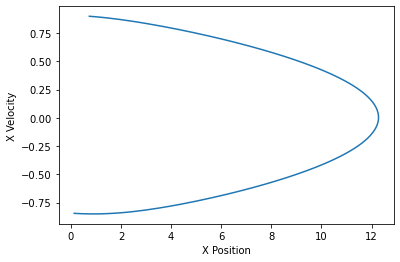

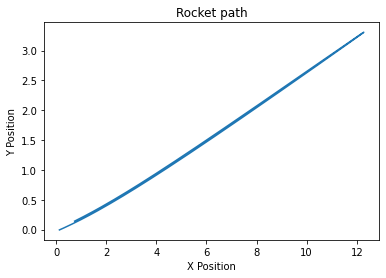

[19] loss: 0.751


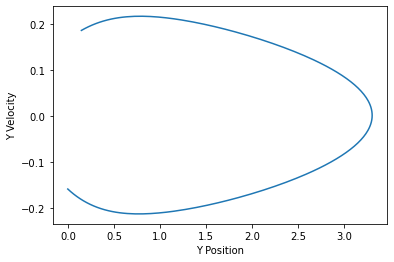

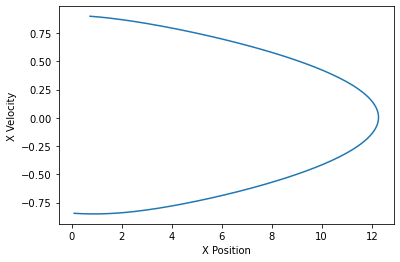

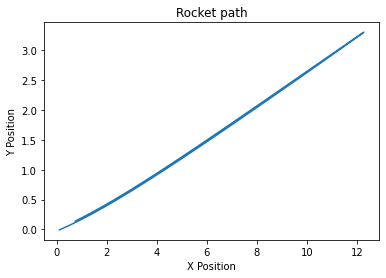

[20] loss: 0.746


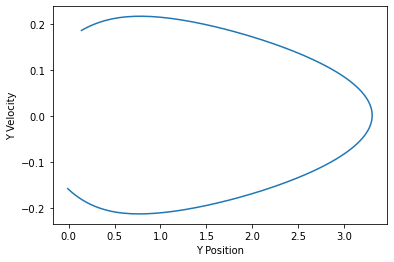

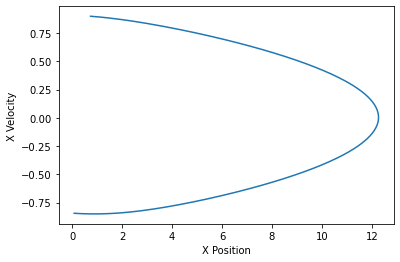

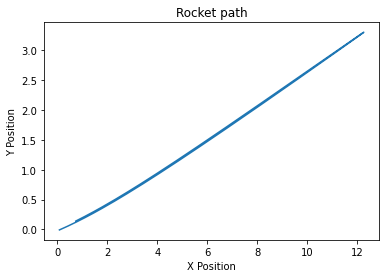

[21] loss: 0.742


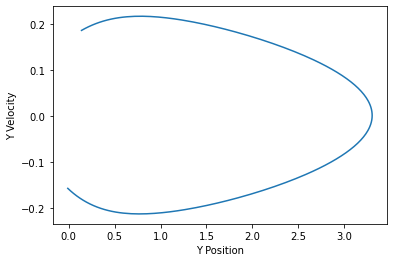

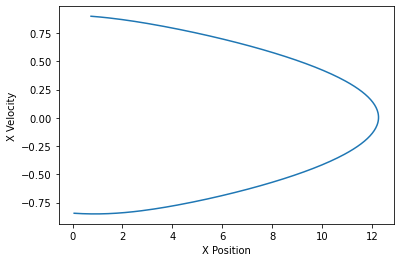

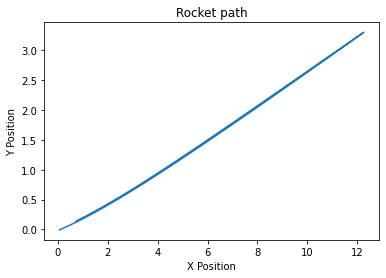

[22] loss: 0.740


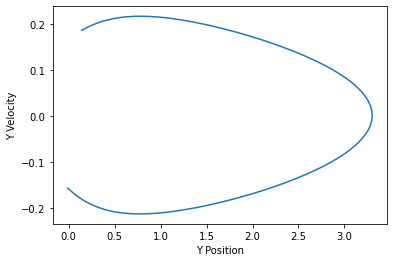

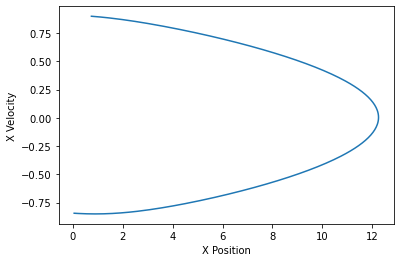

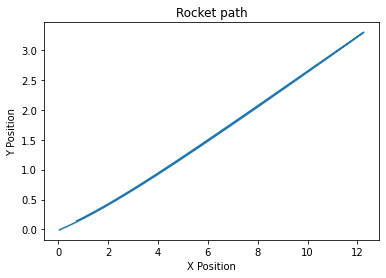

[23] loss: 0.738


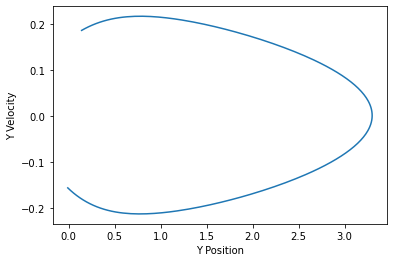

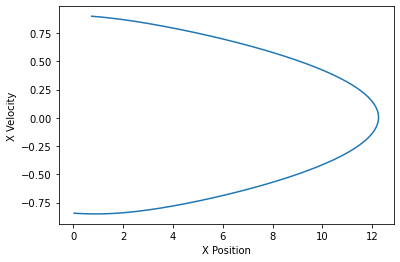

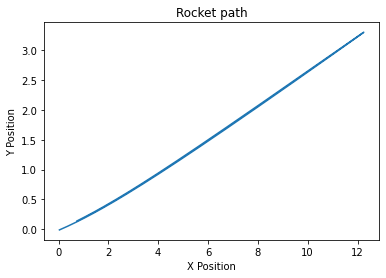

[24] loss: 0.737


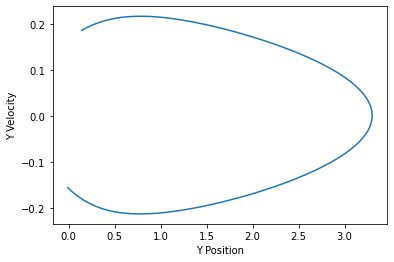

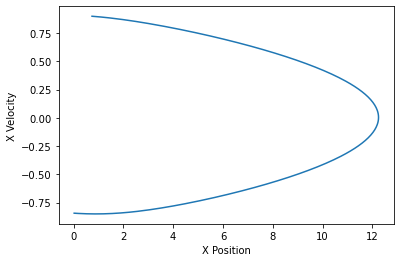

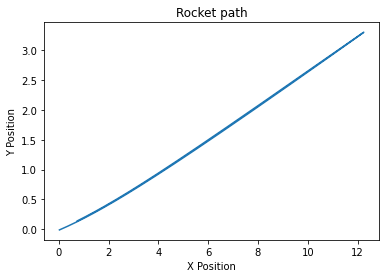

[25] loss: 0.736


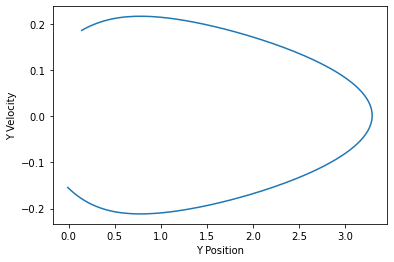

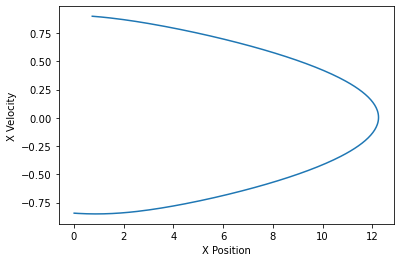

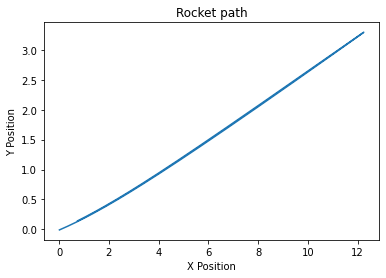

[26] loss: 0.734


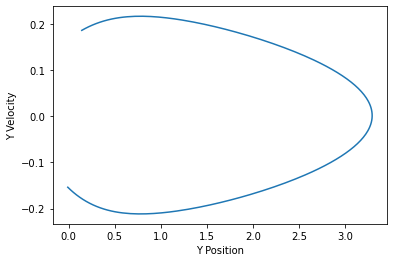

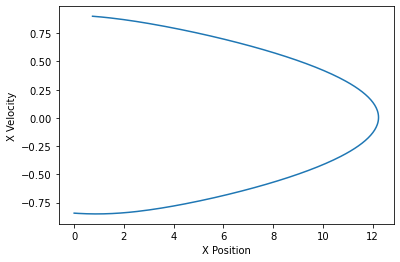

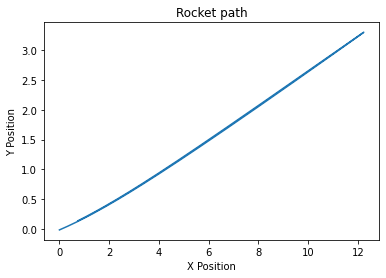

[27] loss: 0.733


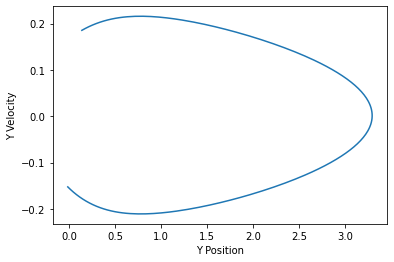

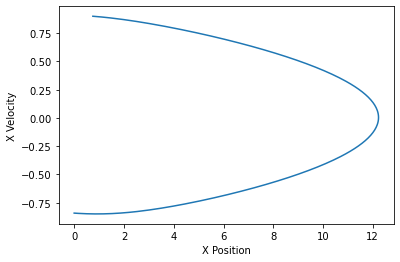

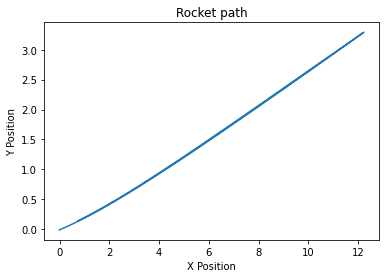

[28] loss: 0.729


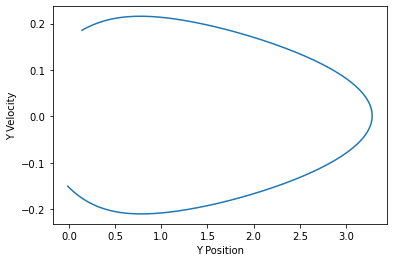

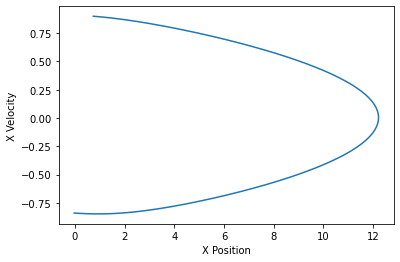

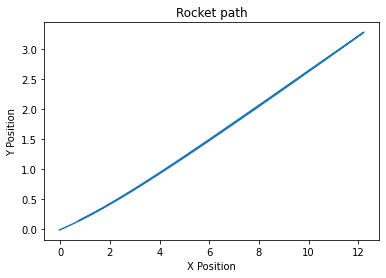

[29] loss: 0.692


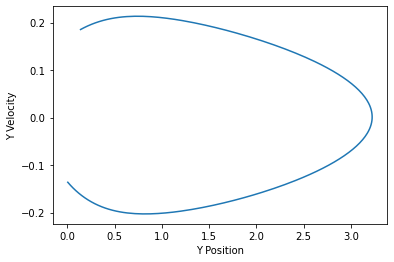

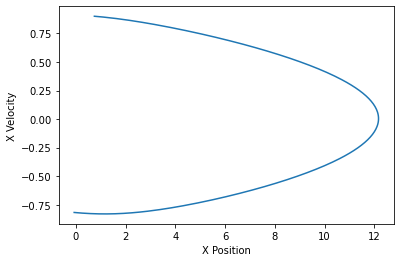

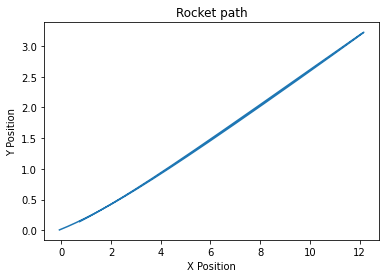

[30] loss: 0.663


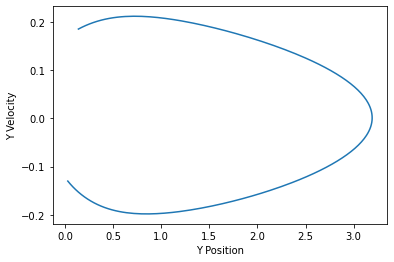

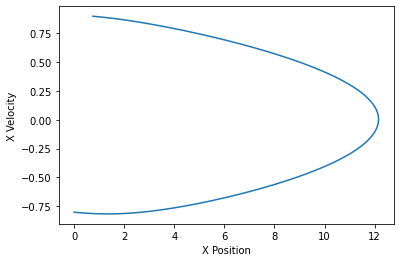

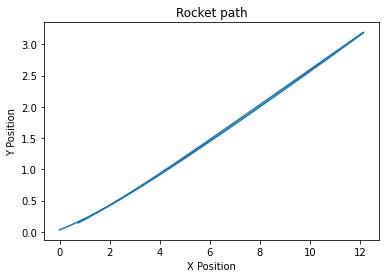

[31] loss: 0.654


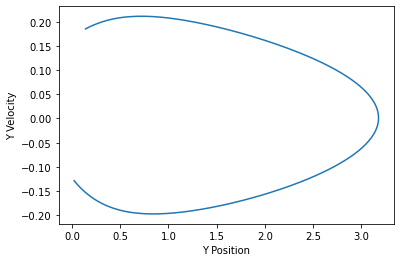

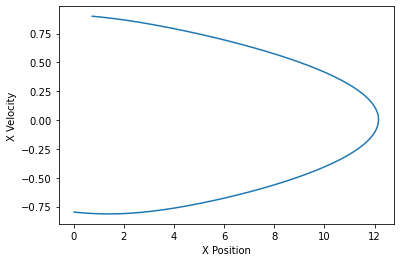

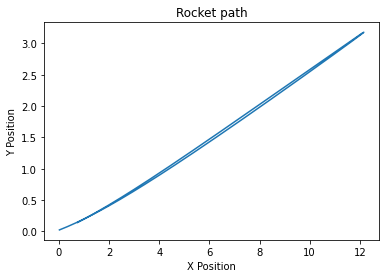

[32] loss: 0.645


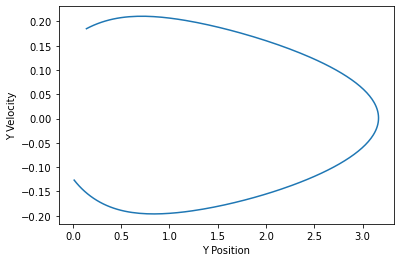

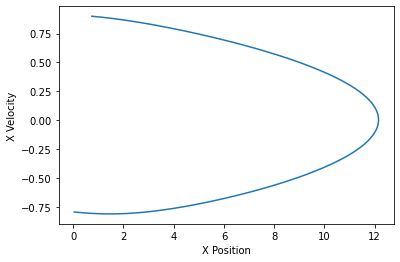

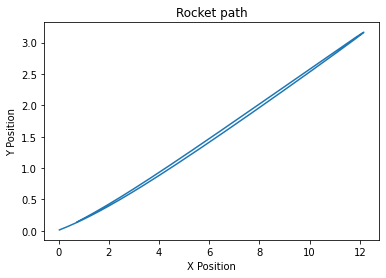

[33] loss: 0.633


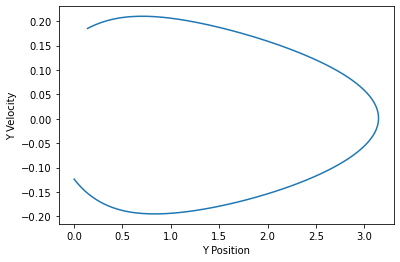

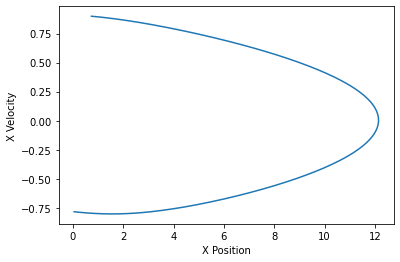

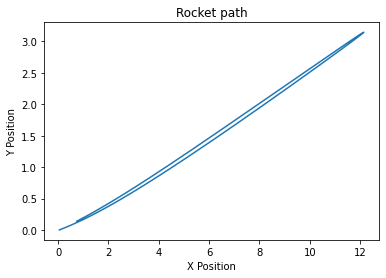

[34] loss: 0.612


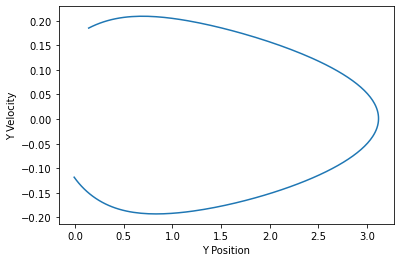

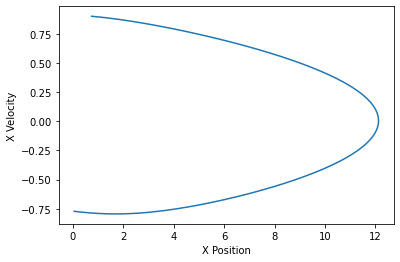

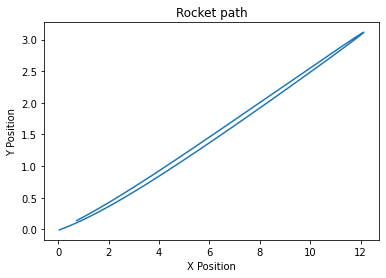

[35] loss: 0.568


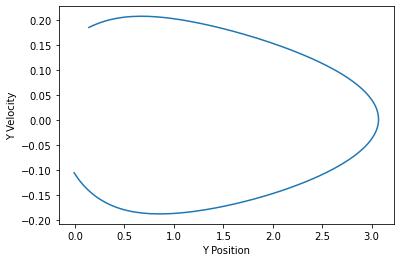

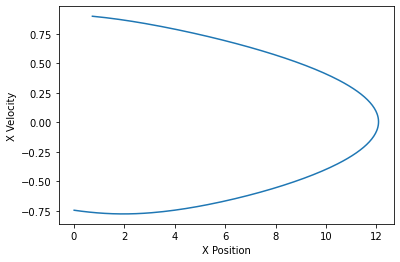

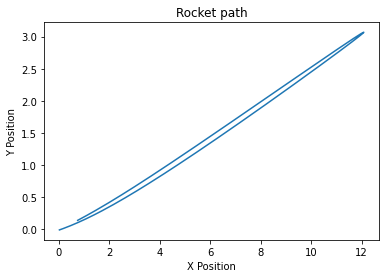

[36] loss: 0.467


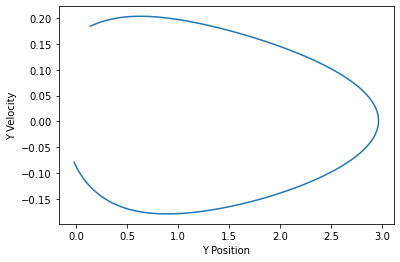

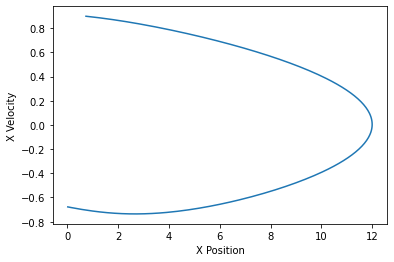

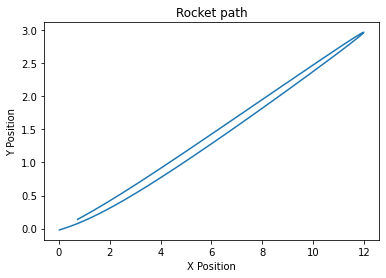

[37] loss: 0.368


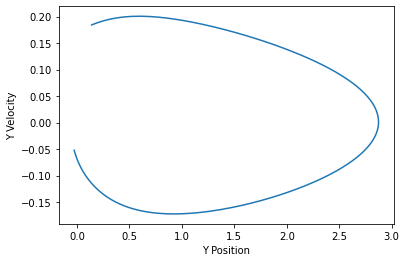

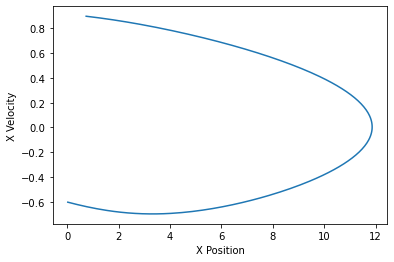

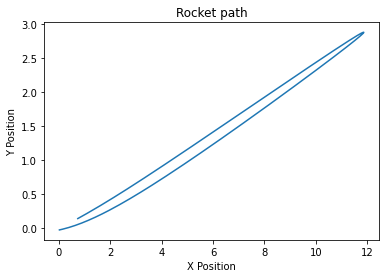

[38] loss: 0.266


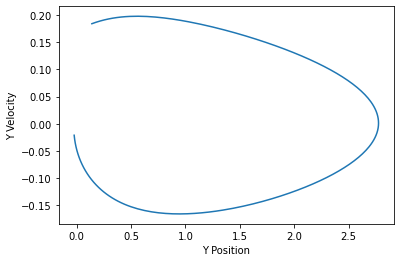

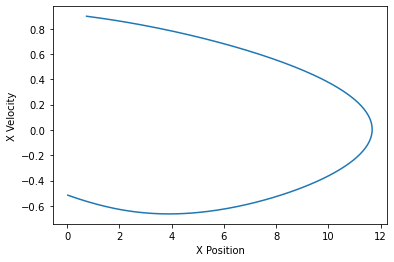

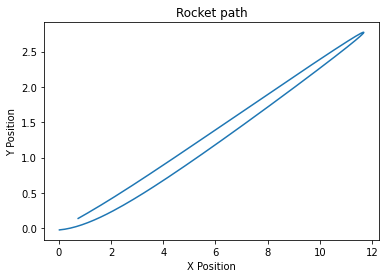

[39] loss: 0.190


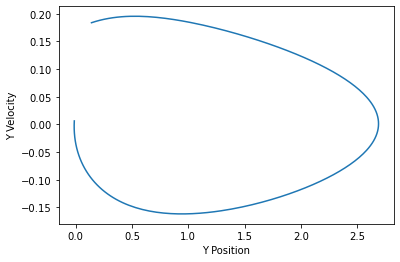

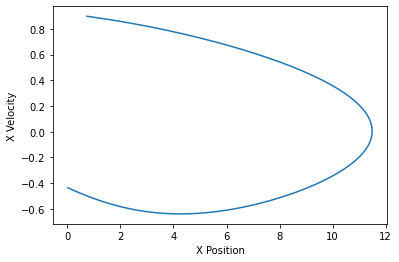

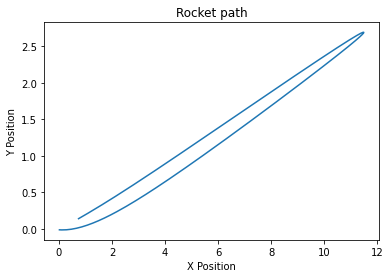

[40] loss: 0.139


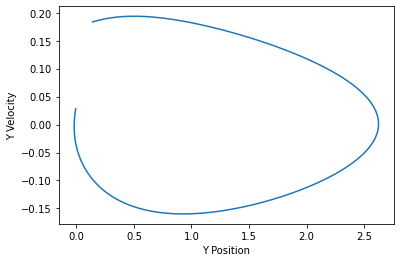

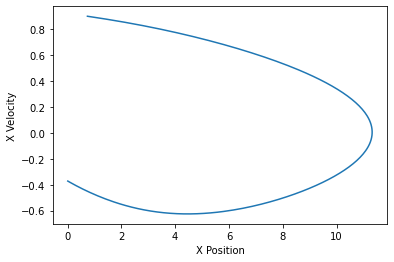

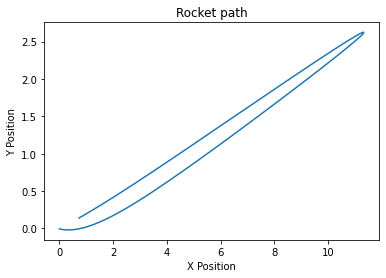

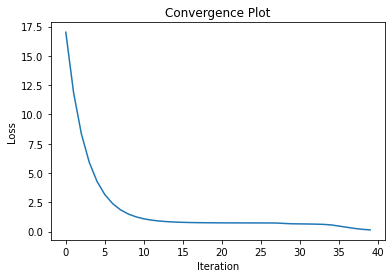

In [22]:
# Now it's time to run the code!

T = 250  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)


# __Project 1: Gradient Based Algorithms and Differentiable Programming__


## Introduction

The following report outlines the objective function, variables, constraints, and assumptions involved in formulating the  above problem. The design space explored during this project was minimizing the amount of error in the landing position of a rocket in both the horizontal($x$) and vertical($y$) directions. An update of the dynamics of the existing model was performed as well as randomization of the initial position and $x$ and $y$ velocities.

## Dynamics

Rocket dynamics is a very complex and nuanced research field all to itself so for the dynamics in the scope of this project assumptions were made to simplify the model. Key simplifications of this model include; no rotation of the rocket body, no decrease in weight as rocket uses fuel, gravity as a constant acceleration in the $y$ direction, and no self correcting forces created by the drag on the rocket body. For the key features added to the model dynamics we have; wind in the $x$ direction effecting the trajectory of the rocket, drag force created by the velocity of the rocket in the $y$ direction, and thrusters included on the bottom and sides of the rocket to increase the movement capabilities. The formulation of the dynamics are as follows:

### Drag
For the following equations we have the variables $C_d$ which represents the drag coefficient, $\rho$ which represents the density of the air, $A$ for the area of the rocket in the direction of drag, and $M$ for the mass of the rocket. to then find the change in velocity from these equations we multiply them all by $\Delta t$.

$$
\begin{aligned}
a_{Dy} = {C_d { \rho v_y^2 \over 2 } A \over M} , \\ 
a_W =  {C_d { \rho v_W^2 \over 2 } A \over M} , \\
a_{Dx} =  {C_d { \rho v_x^2 \over 2 } A \over M}
\end{aligned}
$$

### Position and Velocity
Here the rocket state is determined by the following functions where $d(t)$ is the current position and $d(t+1)$ is the next time step governed by $\Delta t$ and this is the same for the velocity functions shown

$$
\begin{aligned}
d_x(t+1) = d_x(t) + v_x(t) \Delta t, \\
v_x(t+1) = v_x(t) + a_x(t) \Delta t, \\
d_y(t+1) = d_y(t) + v_y(t) \Delta t, \\
v_y(t+1) = v_y(t) + a_y(t) \Delta t, 
\end{aligned}
$$

### Thrust
Here the change in velocity is determined by the acceleration of the thrusters, the change in time, and the action which is either a 1 or a 0 determined by the trained neural network discussed in future sections. Each equation represents a different thruster up, left and right.

$$
\begin{aligned}
\Delta v_y = -a_b \Delta t * action(1), \\
\Delta v_x = -a_b \Delta t * action(2), \\
\Delta v_x = a_b \Delta t * action(3),
\end{aligned}
$$

## Controller
For the controller a neural network was used, this takes a set of inputs and puts them through "hidden" layers that are trained by parameters that will be discussed in the optimization section, then produces a set ouf outputs in this case either a 1 or a 0 that is used for our "action" which is whether to provide thrust or not. the functions used within this neural network are tanh which outputs values from -1 to 1 and sigmoid which outputs values from 0 to 1.we then utilize multiple outputs to provide the multiple actions required to controll each of the thrusters.

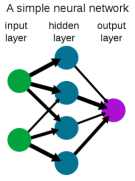

the closed loop controller is as follows:
$$
a(t) = f_{\theta}(x(t))
$$

## Simulation
In this section the actual simulation and trajectory of the rocket is computed creating our iterations. This is also where the optimization problem is formulated containing the objective function, constraints pulled from the dynamics and error calculation which are as follows:

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d_x(t+1) = d_x(t) + v_x(t) \Delta t, \\
\quad & v_x(t+1) = v_x(t) + a_x(t) \Delta t, \\
\quad & d_y(t+1) = d_y(t) + v_y(t) \Delta t, \\
\quad & v_y(t+1) = v_y(t) + a_y(t) \Delta t, \\
\quad & Penalty = sum_{t=0}^T ReLU(-h(t)), \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

we then take this problem and use it to create the objective function which is:

$$
x(t) = d_x(t)+v_x(t)+d_y(t)+v_y(t)+penalty
$$

using this we can find the error because we want the state vector $x(T) = zeros$ using the least square method:

$$
error = ||(0-d_x(t))+(0-v_x(t))+(0-d_y(t))+(0-v_y(t))||^2 + penalty, \\
error = d_x(t)^2+v_x(t)^2+d_y(t)^2+v_y(t)^2+penalty
$$

for the penalty function we have a rectified linear unit applied to the sum of heights and this adds a penalty to the error function if there are any heights less than 0 which would represent a "crash" into the ground the penalty function activates increasing error to attempt to train that out.
This section is also where the random initial conditions are introduced.

## Optimization

Here our optimization algorithm is actually implemented by setting the gradient of the error function equal to zero to find the minimum value. This is done by taking advantage of the package known as pytorch which allows us to build the forward pass of the loss and automatically get the gradient of the function. we then implement gradient descent which is an algorithm that moves iteratively in the path of steepest descent of the gradient to find the minimum value

## Results and Conclusions
In the last portion of the code we see each of the iterations and the loss associated with each one and by the end we can see by the convergence plot that we converge onto a loss of 0 which means that this is the optimal solution. in some instances this may converge onto a loss greater than 0 this could indicate a number of things such as that there isnt enough time given the constraints of the problem for the rocket to find 0 or that we have reached a local minimum. Though the path of the rocket is somewhat odd, this could be due to the wind and drag that is acting on the rocket. In order to have a more accurate model the dynamics could still be improved and as far as the optimization algorithm line search could be implemented as well as a dynamic step size to increase chance of convergence as the complexities of the system rise.

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 